## Project 2
*Alexander Laloi Dybdahl, Viktor Ellevseth, Harald Hobbelhagen*

### Importing libraries

In [6]:
# %pip install numpy==1.25.0
# %pip install --upgrade tensorflow
# %pip install --upgrade keras
# %pip install "numpy<1.25.0"
# %pip install --upgrade scipy
# %pip install opencv-python

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import numpy as np
import scipy.ndimage
import cv2

from PIL import Image
from tqdm import tqdm 
import tensorflow as tf
from keras import layers, models, utils
from keras.models import load_model

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import rotate

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from sklearn.metrics import f1_score


### Loading and preparing images

In [7]:

def load_image(infilename):
    """
    Load an image from a file.
    
    :param infilename: Path to the image file.
    :return: Image data as a numpy array.
    """
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    """
    Convert an image from floating point to uint8 format.
    
    :param img: Floating point image data.
    :return: Image data in uint8 format.
    """
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    """
    Concatenate an image with its ground truth (label) image.
    
    :param img: Original image as a numpy array.
    :param gt_img: Ground truth image (label image) as a numpy array.
    :return: Concatenated image.
    """
    gt_img = np.squeeze(gt_img)
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    """
    Crop an image into patches of a specified size.
    
    :param im: Image data as a numpy array.
    :param w: Width of each patch.
    :param h: Height of each patch.
    :return: List of image patches.
    """
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

def load_images_from_directory(directory, file_names, max_images=100):
    """
    Load a specified number of images from a directory.

    :param directory: Path to the directory containing images.
    :param file_names: List of file names to load.
    :param max_images: Maximum number of images to load.
    :return: List of loaded images.
    """
    images = [load_image(os.path.join(directory, file_name)) for file_name in file_names[:max_images]]
    return images


### Displaying functions

In [8]:
def make_img_overlay(img, predicted_img):
    """
    Create an overlay image showing the prediction on top of the original image.

    :param img: Original image as a numpy array.
    :param predicted_img: Prediction image as a numpy array (binary mask).
    :return: Image object with overlay.
    """
    # Squeeze the singleton dimension from predicted_img if it exists
    predicted_img = np.squeeze(predicted_img, axis=-1)

    # Get dimensions of the original image
    w, h = img.shape[0], img.shape[1]

    # Create an empty color mask with the same dimensions
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)

    # Set the red channel of the mask to the prediction mask * 255
    color_mask[:, :, 0] = predicted_img * 255

    # Convert the original image to an 8-bit format (0-255 range)
    img8 = img_float_to_uint8(img)

    # Convert numpy arrays to PIL Image objects for blending
    # Convert to RGBA for alpha channel (transparency)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")

    # Blend the original image with the color mask using alpha compositing
    new_img = Image.blend(background, overlay, 0.2)

    return new_img

def display_overlay(test_image, prediction):
    """
    Display the overlay image showing the prediction on top of the test image.

    :param test_image: The test image as a numpy array.
    :param prediction: The prediction mask as a numpy array.
    """
    # Create the overlay image
    overlay_img = make_img_overlay(test_image, prediction)

    # Create a figure and display the overlay image
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_img)
    plt.title('Overlay Image')
    plt.axis('off')  # Turn off the axis
    plt.show()

def display(display_list):
    """
    Display a list of images/masks in a single row.

    :param display_list: List of images/masks to display.
    """
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        image = display_list[i]
        
        # Display the image or mask appropriately based on its dimension
        if image.ndim == 2:  # Grayscale mask
            plt.imshow(image, cmap='gray')
        elif image.ndim == 3 and image.shape[-1] == 1:  # Single-channel mask
            plt.imshow(np.squeeze(image, axis=-1), cmap='gray')
        else:  # RGB Image
            plt.imshow(tf.keras.utils.array_to_img(image))
        
        plt.axis('off')
    plt.show()


### Data augmentation and preproccesing

In [9]:

def elastic_deform(image, alpha, sigma):
    """
    Apply elastic deformation to the image.

    :param image: A numpy array of shape (H, W, C) representing the image.
    :param alpha: The scaling factor for deformation intensity.
    :param sigma: The standard deviation of the Gaussian filter used for smoothing.
    :return: Deformed image as a numpy array.
    """
    assert len(image.shape) == 3, "Image should be HxWxC"

    # Random displacement fields
    dx = scipy.ndimage.gaussian_filter((np.random.rand(*image.shape[:2]) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = scipy.ndimage.gaussian_filter((np.random.rand(*image.shape[:2]) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # Create meshgrid for displacements
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    x, y = np.clip(x + dx, 0, image.shape[1] - 1), np.clip(y + dy, 0, image.shape[0] - 1)

    # Apply displacement
    deformed_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        deformed_image[:, :, i] = scipy.ndimage.map_coordinates(image[:, :, i], [y, x], order=1)

    return deformed_image


In [10]:

def random_crop(img, mask, crop_size):
    """
    Randomly crop an image and its corresponding mask.

    :param img: The image to crop, a numpy array of shape (H, W, C).
    :param mask: The corresponding mask to crop, a numpy array of shape (H, W).
    :param crop_size: The size of the crop (height, width).
    
    :return: Cropped image and mask.
    """
    if (img.shape[0] < crop_size[0]) or (img.shape[1] < crop_size[1]):
        raise ValueError("Crop size must be smaller than image size")

    height, width = img.shape[0], img.shape[1]
    crop_height, crop_width = crop_size

    # Randomly choose the top-left corner of the cropping box
    x = random.randint(0, width - crop_width)
    y = random.randint(0, height - crop_height)

    cropped_img = img[y:y+crop_height, x:x+crop_width, :]
    cropped_mask = mask[y:y+crop_height, x:x+crop_width]

    return cropped_img, cropped_mask

In [11]:

def resize_and_pad(images, masks, new_height, new_width):
    """
    Resize images and masks to new dimensions, maintaining aspect ratio, and add padding if necessary.

    :param images: Numpy array of images.
    :param masks: Numpy array of masks.
    :param new_height: New height after resizing and padding.
    :param new_width: New width after resizing and padding.
    
    :return: Resized and padded images and masks.
    """
    resized_images = np.zeros((len(images), new_height, new_width, images.shape[3]))
    resized_masks = np.zeros((len(masks), new_height, new_width))

    for i, (img, mask) in enumerate(zip(images, masks)):
        # Calculate the aspect ratio and determine dimensions to maintain aspect ratio
        h, w = img.shape[:2]
        scale = min(new_width / w, new_height / h)
        scaled_w, scaled_h = int(w * scale), int(h * scale)

        # Resize image and mask
        resized_img = cv2.resize(img, (scaled_w, scaled_h), interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask, (scaled_w, scaled_h), interpolation=cv2.INTER_NEAREST)

        # Calculate padding sizes
        pad_w = (new_width - scaled_w) // 2
        pad_h = (new_height - scaled_h) // 2

        # Pad resized image and mask
        resized_images[i] = np.pad(resized_img, ((pad_h, new_height - scaled_h - pad_h), (pad_w, new_width - scaled_w - pad_w), (0, 0)), mode='constant')
        resized_masks[i] = np.pad(resized_mask, ((pad_h, new_height - scaled_h - pad_h), (pad_w, new_width - scaled_w - pad_w)), mode='constant')

    return resized_images, resized_masks

def pad_to_size(img, target_size):
    """
    Pad an image to a target size.

    :param img: Image to pad.
    :param target_size: Target size as a tuple (height, width).
    :return: Padded image.
    """
    height, width = img.shape[:2]
    pad_height = (target_size[0] - height) // 2
    pad_width = (target_size[1] - width) // 2

    # Calculate padding for even and odd dimensions
    pad_height1, pad_height2 = pad_height, target_size[0] - height - pad_height
    pad_width1, pad_width2 = pad_width, target_size[1] - width - pad_width

    return np.pad(img, ((pad_height1, pad_height2), (pad_width1, pad_width2), (0, 0)), mode='constant')


In [12]:
def augment_data(images, masks, augment_options, original_size):
    """
    Apply data augmentation techniques to images and masks.

    :param images: List or numpy array of images.
    :param masks: List or numpy array of corresponding masks.
    :param augment_options: Dictionary with options for different augmentations.
    :param original_size: Original size of the images (height, width).
    
    :return: Augmented images and masks.
    """
    augmented_images = []
    augmented_masks = []

    # Rotation
    if augment_options.get("rotation"):
        angles = augment_options["rotation"]["angles"]
        print(f"Applying rotation in {angles} angles")
        for img, mask in zip(images, masks):
            for angle in angles:
                augmented_images.append(rotate(img, angle, preserve_range=True))
                augmented_masks.append(rotate(mask, angle, preserve_range=True))

    # Elastic Deformation
    if augment_options.get("deformation"):
        print("Applying deformation")
        alpha, sigma = augment_options["deformation"]["alpha"], augment_options["deformation"]["sigma"]
        for img, mask in zip(images, masks):
            augmented_images.append(elastic_deform(img, alpha, sigma))
            augmented_masks.append(elastic_deform(mask, alpha, sigma))

    # Random Cropping and Padding
    if augment_options.get("cropping"):
        print("Applying cropping")
        crop_height, crop_width = augment_options["cropping"]["height"], augment_options["cropping"]["width"]
        for img, mask in zip(images, masks):
            cropped_img, cropped_mask = random_crop(img, mask, (crop_height, crop_width))
            padded_img = pad_to_size(cropped_img, original_size)
            padded_mask = pad_to_size(cropped_mask, original_size)
            augmented_images.append(padded_img)
            augmented_masks.append(padded_mask)

    return np.array(augmented_images), np.array(augmented_masks)


### Performing loading

In [24]:
dir = "/Users/Alexander/OneDrive - NTNU/NTNU/7. Semester/CS-433 Machine Learning/Machine Learning Project 2/ML-Project-2/"

In [25]:
root_dir = "/Users/Alexander/OneDrive - NTNU/NTNU/7. Semester/CS-433 Machine Learning/Machine Learning Project 2/ML-Project-2/"

# Load original images
image_dir = os.path.join(root_dir, "training/images/")
image_files = os.listdir(image_dir)
n = min(100, len(image_files))
print(f"Loading {n} original images")
imgs = load_images_from_directory(image_dir, image_files, max_images=n)

# Load ground truth images
gt_dir = os.path.join(root_dir, "training/groundtruth/")
print(f"Loading {n} ground truth images")
gt_imgs = load_images_from_directory(gt_dir, image_files, max_images=n)
gt_imgs = np.expand_dims(gt_imgs, axis=-1)  # Add an extra dimension


Loading 100 original images
Loading 100 ground truth images


### Defining parameters

In [15]:
# Constant parameters
original_height, original_width = 400, 400
test_size = 0.30
random_state = 42
threshold = 0.5

# U-net hyperparameters
activation='relu'
depth = 4
dropout_rate = 0.1
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']
patience = 3
batch_size = 10
epochs = 25

### Performing augmentation

In [16]:
# Choose augmentation options
augment_options = {
    "rotation": {"angles": [0, 45, 90, 180, 270]}
    , "deformation": {"alpha": 34, "sigma": 4}
    # , "cropping": {"height": 200, "width": 200}
}

# Apply augmentations
augmented_imgs, augmented_gt_imgs = augment_data(imgs, gt_imgs, augment_options, (original_height, original_width))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(augmented_imgs, augmented_gt_imgs, test_size=0.30, random_state=42)

# Normalization
X_train = X_train.astype('float32') #/ 255
X_test = X_test.astype('float32') #/ 255

# Make sure that the gt are binary 0 and 1
y_train = (y_train > 0.5).astype(np.float32)
y_test = (y_test > 0.5).astype(np.float32)


Applying rotation in [0, 45, 90, 180, 270] angles


Applying deformation


In [17]:
print("Dataset Summary:\n")

print(f"Training Images:\n - Min Value: {X_train.min():.4f}\n - Max Value: {X_train.max():.4f}\n - Shape: {X_train.shape}")
print(f"Test Images:\n - Min Value: {X_test.min():.4f}\n - Max Value: {X_test.max():.4f}\n - Shape: {X_test.shape}")

print(f"Training Masks:\n - Min Value: {y_train.min():.4f}\n - Max Value: {y_train.max():.4f}\n - Shape: {y_train.shape}")
print(f"Test Masks:\n - Min Value: {y_test.min():.4f}\n - Max Value: {y_test.max():.4f}\n - Shape: {y_test.shape}")

Dataset Summary:

Training Images:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (420, 400, 400, 3)
Test Images:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (180, 400, 400, 3)
Training Masks:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (420, 400, 400, 1)
Test Masks:
 - Min Value: 0.0000
 - Max Value: 1.0000
 - Shape: (180, 400, 400, 1)


### Building U-net

In [18]:
def build_unet(img_height, img_width, img_channels, num_classes, start_filters, depth, dropout_rate, activation='relu'):
    """
    Build a U-Net model with customizable parameters.

    :param img_height: Height of the input images.
    :param img_width: Width of the input images.
    :param img_channels: Number of channels in the input images.
    :param num_classes: Number of output classes.
    :param start_filters: Number of filters in the first layer.
    :param depth: Depth of the U-Net.
    :param dropout_rate: Dropout rate for regularization.
    :param activation: Activation function to use.
    
    :return: A Keras model representing the U-Net.
    """
    inputs = layers.Input((img_height, img_width, img_channels))

    # Contraction path
    contraction_layers = []
    x = inputs
    for i in range(depth):
        x = layers.Conv2D(start_filters * (2 ** i), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(i * dropout_rate)(x)
        x = layers.Conv2D(start_filters * (2 ** i), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        contraction_layers.append(x)
        x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(start_filters * (2 ** depth), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(depth * dropout_rate)(x)
    x = layers.Conv2D(start_filters * (2 ** depth), (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(x)

    # Expansive path
    for i in reversed(range(depth)):
        x = layers.Conv2DTranspose(start_filters * (2 ** i), (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([x, contraction_layers[i]])
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    return models.Model(inputs=[inputs], outputs=[outputs])

activations = ['relu', 'leaky_relu', 'elu']

# Building u-net
model = build_unet(original_height, original_width, 3, 1, 16, 4, 0.1, activation='relu')  # Customize as needed
model.summary()  # View the model architecture



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 400, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 400, 400, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 400, 400, 16)         2320      ['dropout[0][0]']             
                                                                                            

In [19]:
# from keras.backend import clear_session
# clear_session()

IMG_WIDTH = 400
IMG_HEIGHT = 400
IMG_CHANNELS = 3

num_classes = 1

inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Contraction path
c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = layers.Dropout(0.1)(c1)
c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = layers.BatchNormalization()(c1)
r1 = layers.ReLU()(b1)
p1 = layers.MaxPooling2D((2, 2))(r1)

c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = layers.Dropout(0.1)(c2)
c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = layers.BatchNormalization()(c2)
r2 = layers.ReLU()(b2)
p2 = layers.MaxPooling2D((2, 2))(r2)
 
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = layers.BatchNormalization()(c3)
r3 = layers.ReLU()(b3)
p3 = layers.MaxPooling2D((2, 2))(r3)
 
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = layers.BatchNormalization()(c4)
r4 = layers.ReLU()(b4)
p4 = layers.MaxPooling2D(pool_size=(2, 2))(r4)

# Bottleneck
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = layers.BatchNormalization()(c5)
r5 = layers.ReLU()(b5)
c5 = layers.Dropout(0.3)(r5)
c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


# Expansive path 
u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
u6 = layers.BatchNormalization()(u6)
u6 = layers.ReLU()(u6)
 
u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = layers.concatenate([u7, c3])
u7 = layers.BatchNormalization()(u7)
u7 = layers.ReLU()(u7)
 
u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = layers.concatenate([u8, c2])
u8 = layers.BatchNormalization()(u8)
u8 = layers.ReLU()(u8)
 
u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = layers.concatenate([u9, c1], axis=3)
u9 = layers.BatchNormalization()(u9)
u9 = layers.ReLU()(u9)

outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

In [20]:
# Compile the model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 400, 400, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 400, 400, 16)         0         ['conv2d_11[0][0]']           
                                                                                                  
 conv2d_12 (Conv2D)          (None, 400, 400, 16)         2320      ['dropout_5[0][0]']           
                                                                                           

### Plotting model

In [21]:
# utils.plot_model(model, "model.png")

### Load existing model

In [26]:
# Load the model
model = load_model(root_dir + 'models/model_0.0669_0.9679_0.1326_0.9501.keras')

### Performing fitting

In [28]:
# Assuming y_train is your binary labeled mask with shape (num_samples, height, width)
# Flatten y_train to get a 1D array of all pixel labels
labels = y_train.flatten()

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=labels)

# Create a dictionary to pass to fit function
class_weights = {0: class_weights[0], 1: class_weights[1]}

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, y_train, class_weight=class_weights, validation_data=(X_test, y_test), batch_size=20, epochs=5, callbacks=callbacks)

Epoch 1/5


21/21 [==============================] - 360s 15s/step - loss: 0.0699 - accuracy: 0.9680 - val_loss: 0.1288 - val_accuracy: 0.9516
Epoch 2/5


### Saving the fitted model 

In [ ]:
# Get the last values from the history
last_loss = history.history['loss'][-1]
last_accuracy = history.history['accuracy'][-1]
last_val_loss = history.history['val_loss'][-1]
last_val_accuracy = history.history['val_accuracy'][-1]

# Save the model
filename = f"models/model_{last_loss:.4f}_{last_accuracy:.4f}_{last_val_loss:.4f}_{last_val_accuracy:.4f}.keras"
model.save(root_dir + filename)

### Plotting training loss vs validation loss

In [ ]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig("train_validation_loss.png")
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

### Displaying prediction on test set

In [ ]:
def predictions_to_majority_patches(predictions, patch_size=(16, 16)):
    """
    Convert model predictions to majority-voted patches.

    :param predictions: 2D array of predictions.
    :param patch_size: Tuple indicating the size of patches (height, width).
    :return: 2D array where each element represents the majority prediction for a patch.
    """
    height, width = predictions.shape[:2]
    patch_height, patch_width = patch_size
    num_patches_vertically = height // patch_height
    num_patches_horizontally = width // patch_width

    # Initialize an array to store the majority vote for each patch
    majority_patches = np.zeros((num_patches_vertically, num_patches_horizontally), dtype=np.uint8)

    # Iterate over the patches and calculate the majority value
    for i in range(num_patches_vertically):
        for j in range(num_patches_horizontally):
            patch = predictions[i * patch_height: (i + 1) * patch_height, j * patch_width: (j + 1) * patch_width]
            majority_value = np.argmax(np.bincount(patch.flatten()))
            majority_patches[i, j] = majority_value

    return majority_patches

def predictions_to_thresholded_patches(predictions, patch_size=(16, 16), threshold=0.5):
    """
    Convert model predictions to patches based on a threshold.

    :param predictions: 2D array of predictions.
    :param patch_size: Tuple indicating the size of patches (height, width).
    :param threshold: Proportion of foreground pixels required to label a patch as foreground.
    :return: 2D array where each element represents the label for a patch.
    """
    height, width = predictions.shape[:2]
    patch_height, patch_width = patch_size
    num_patches_vertically = height // patch_height
    num_patches_horizontally = width // patch_width

    # Initialize an array to store the label for each patch
    thresholded_patches = np.zeros((num_patches_vertically, num_patches_horizontally), dtype=np.uint8)

    # Iterate over the patches and calculate the label based on the threshold
    for i in range(num_patches_vertically):
        for j in range(num_patches_horizontally):
            patch = predictions[i * patch_height: (i + 1) * patch_height, j * patch_width: (j + 1) * patch_width]
            foreground_proportion = np.mean(patch)
            thresholded_patches[i, j] = int(foreground_proportion > threshold)

    return thresholded_patches


1/1 [==============================] - 0s 79ms/step


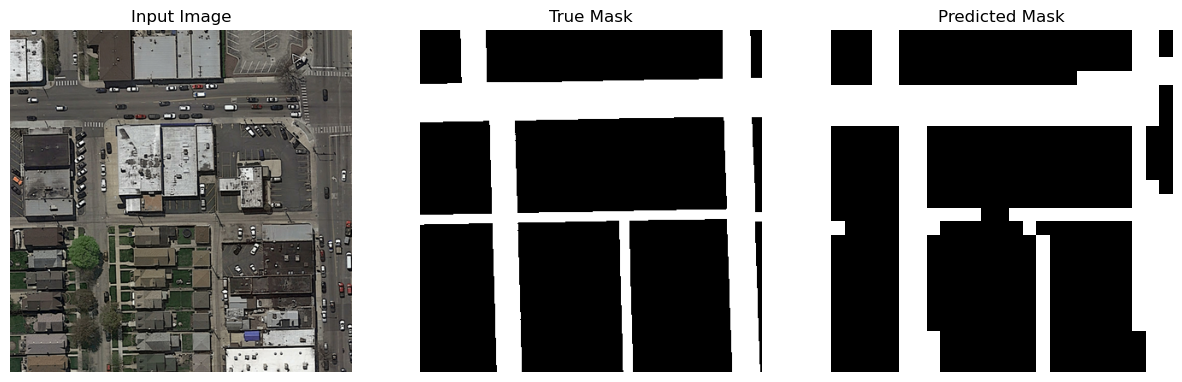

In [ ]:
# Displaying arbitrary image
i = random.randint(0, len(X_test) - 1)
sample_image = X_test[i]
sample_mask = y_test[i]

# Predict the mask for the sample image
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)

# Convert the predicted mask into patches
predicted_majority_patches = predictions_to_thresholded_patches(predicted_mask, threshold=0.5)

# Display the original image, true mask, and predicted mask
display([sample_image, sample_mask, predicted_majority_patches])

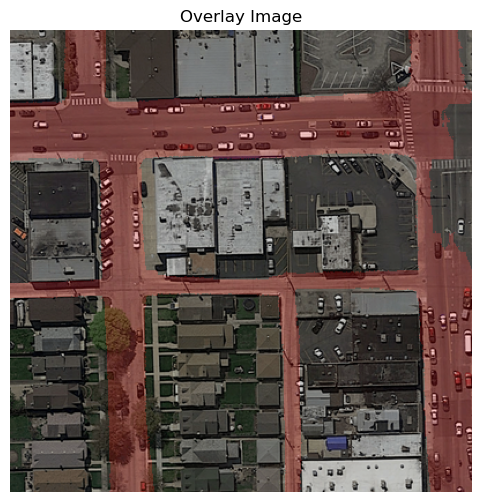

In [ ]:
display_overlay(sample_image, predicted_mask)

### Parameter tuning for threshold for predicting patches

In [ ]:
def evaluate_thresholds(X_test, y_test, model, thresholds):
    """
    Evaluate different thresholds for converting model predictions to binary masks using batch processing.

    :param X_test: Test set images.
    :param y_test: True masks for the test set.
    :param model: Trained model for making predictions.
    :param thresholds: List of thresholds to evaluate.
    :return: Dictionary with F1 scores for each threshold.
    """
    f1_scores = {}

    # Predict for all images at once
    predictions = model.predict(X_test)  # Assuming X_test is a numpy array
    predictions_flat = predictions.reshape(-1, predictions.shape[-1])  # Flatten predictions

    # Flatten all true masks
    y_test_flat = y_test.reshape(-1, y_test.shape[-1]).flatten()

    for threshold in thresholds:
        # Apply threshold to all predictions
        predicted_masks_flat = (predictions_flat > threshold).astype(np.uint8)

        # Compute F1 score
        f1 = f1_score(y_test_flat, predicted_masks_flat)
        f1_scores[threshold] = f1

    return f1_scores

# Performing parameter tuning
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
f1_scores = evaluate_thresholds(X_test, y_test, model, thresholds)
for threshold, score in f1_scores.items():
    print(f"Threshold: {threshold}, F1 Score: {score:.4f}")

6/6 [==============================] - 8s 1s/step
Threshold: 0.3, F1 Score: 0.8620
Threshold: 0.4, F1 Score: 0.8720
Threshold: 0.5, F1 Score: 0.8800
Threshold: 0.6, F1 Score: 0.8869
Threshold: 0.7, F1 Score: 0.8926
Threshold: 0.8, F1 Score: 0.8958
Threshold: 0.9, F1 Score: 0.8903


### Loading test set images and predict

In [ ]:
def load_images_from_subfolders(root_dir, n=50):
    """
    Load images from subfolders within a specified directory.

    :param root_dir: Root directory containing image subfolders.
    :param n: Number of subfolders to process.
    :return: List of loaded images.
    """
    imgs = []

    for i in range(1, n + 1):
        subfolder_name = f"test_{i}"
        image_dir = os.path.join(root_dir, subfolder_name)
        
        if os.path.isdir(image_dir):
            files = os.listdir(image_dir)
            if files:
                image_path = os.path.join(image_dir, files[0])
                image = load_image(image_path)
                imgs.append(image)

    return np.array(imgs)

# Loading images
test_root_dir = root_dir + "test_set_images"
test_images = load_images_from_subfolders(test_root_dir, n=50)


In [ ]:
def predict_images(model, images, threshold=0.5):
    """
    Predict each image using the provided model.

    :param model: Trained model for making predictions.
    :param images: Numpy array of images to predict.
    :param threshold: Threshold to convert predictions to binary format.
    :return: Binary predictions for each image as a numpy array.
    """
    predictions = []

    for image in images:
        prediction = model.predict(image[tf.newaxis, ...])[0]
        predicted_mask = (prediction > threshold).astype(np.uint8)
        predictions.append(predicted_mask)

    return np.array(predictions)

# Predicting images
predictions = predict_images(model, test_images)

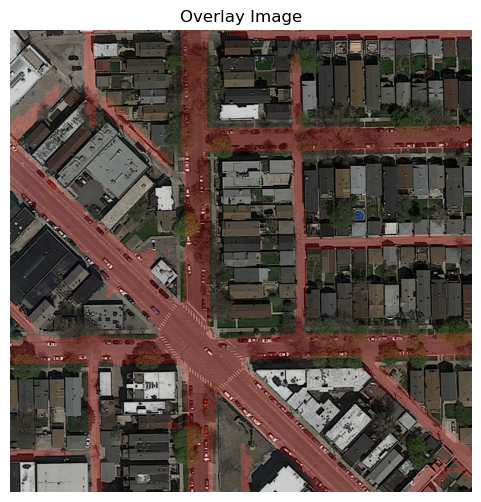

In [ ]:
# Displaying arbitrary image
i = random.randint(0, len(test_images) - 1)
display_overlay(test_images[i], predictions[i])

### Creating submission csv

In [ ]:
def create_submission_entries(predictions, patch_size=16, threshold=0.25):
    """
    Create submission entries from predicted images.

    :param predictions: Numpy array of predicted images.
    :param patch_size: Size of the patches to be used for submission entries.
    :param threshold: Threshold for deciding the label of a patch.
    :return: DataFrame containing submission entries.
    """
    submission_entries = []

    for img_index in range(predictions.shape[0]):
        image = predictions[img_index, :, :, 0]  # Squeeze out the last dimension for single-channel images
        for j in range(0, image.shape[1], patch_size):  # Iterate columns
            for i in range(0, image.shape[0], patch_size):  # Iterate rows
                patch = image[i:i + patch_size, j:j + patch_size]
                label = 1 if np.mean(patch) > threshold else 0
                submission_entries.append([f"{img_index+1:03d}_{j}_{i}", label])

    return pd.DataFrame(submission_entries, columns=['id', 'prediction'])

def save_submission_to_csv(submission_df, filename):
    """
    Save the submission DataFrame to a CSV file.

    :param submission_df: DataFrame containing submission entries.
    :param filename: Name of the CSV file to save.
    """
    submission_df.to_csv(filename, index=False)

# Saving to submission file
submission_df = create_submission_entries(predictions)
save_submission_to_csv(submission_df, root_dir + 'sample_submission.csv')